## **О наборе данных (About Dataset)**

**Источник:** https://www.kaggle.com/datasets/ludocielbeckett/health-risk-prediction-anonymized-real-data

### **Описание (Description)**

Этот набор данных содержит реальные медицинские данные пациентов, которые были тщательно очищены и анонимизированы для защиты конфиденциальности. Он включает витальные признаки и клинические параметры для 1000 пациентов, а также соответствующие уровни риска для их здоровья (Нормальный, Низкий, Средний, Высокий).

Набор данных предназначен для машинного обучения, анализа данных и исследований в области медицинской аналитики. Его можно использовать для построения прогностических моделей, которые помогают медицинским работникам в раннем выявлении пациентов высокого риска и принятии более обоснованных врачебных решений.

**Столбцы (Columns):**

*   **Patient_ID** – Уникальный анонимизированный идентификатор пациента.
*   **Respiratory_Rate** – Частота дыхания (дыхательных движений в минуту).
*   **Oxygen_Saturation** – Сатурация кислорода, уровень насыщения крови кислородом (%).
*   **O2_Scale** – Используемая шкала кислородной терапии.
*   **Systolic_BP** – Систолическое артериальное давление (мм рт. ст.).
*   **Heart_Rate** – Частота сердечных сокращений (ударов в минуту).
*   **Temperature** – Температура тела (°C).
*   **Consciousness** – Уровень сознания (A = Ясное, P = Реакция на боль, C = Спутанное, V = Реакция на голос, U = Не реагирует).
*   **On_Oxygen** – Пользуется ли пациент дополнительным кислородом (0 = Нет, 1 = Да).
*   **Risk_Level** – Целевая переменная (Нормальный, Низкий, Средний, Высокий).

**Потенциальные области применения (Potential Use Cases):**

*   Разработка моделей машинного обучения для классификации рисков.
*   Выявление наиболее критичных признаков, влияющих на уровень риска пациента.
*   Медицинские симуляции и академические исследовательские проекты.
*   Создание систем поддержки врачебных решений (СППР).

## **Ход работы**

### **Импорт библиотек и загрузка датасета**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from itertools import combinations

%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
df = pd.read_csv('Health_Risk_Dataset.csv')

In [3]:
df.describe()

,Respiratory_Rate,Oxygen_Saturation,O2_Scale,Systolic_BP,Heart_Rate,Temperature,On_Oxygen
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,21.511000,92.59000,1.124000,106.160000,98.460000,37.921000,0.274000
std,5.287517,4.47302,0.329746,17.897562,19.694626,1.113696,0.446232
min,12.000000,74.00000,1.000000,50.000000,60.000000,35.600000,0.000000
25%,17.000000,90.00000,1.000000,94.000000,84.000000,37.100000,0.000000
50%,20.000000,94.00000,1.000000,109.000000,95.500000,37.800000,0.000000
75%,25.000000,96.00000,1.000000,119.000000,109.000000,38.600000,1.000000
max,40.000000,100.00000,2.000000,146.000000,163.000000,41.800000,1.000000


In [4]:
df.head()

,Patient_ID,Respiratory_Rate,Oxygen_Saturation,O2_Scale,Systolic_BP,Heart_Rate,Temperature,Consciousness,On_Oxygen,Risk_Level
0,P0522,25,96,1,97,107,37.5,A,0,Medium
1,P0738,28,92,2,116,151,38.5,P,1,High
2,P0741,29,91,1,79,135,38.4,A,0,High
3,P0661,24,96,1,95,92,37.3,A,0,Medium
4,P0412,20,96,1,97,97,37.4,A,0,Low


### **Добавление нового атрибута**

Новый атрибут - **Total_Stress**, вычисляется как сумма отклонений от нормы атрибутов: **Respiratory_Dev**, **Heart_Dev**, **Temp_Dev**, **BP_Dev**

In [5]:
def deviation(value, low, high):
    if value < low:
        return low - value
    elif value > high:
        return value - high
    else:
        return 0

df['Respiratory_Dev'] = df['Respiratory_Rate'].apply(lambda x: deviation(x, 12, 20))
df['Heart_Dev'] = df['Heart_Rate'].apply(lambda x: deviation(x, 60, 100))
df['Temp_Dev'] = df['Temperature'].apply(lambda x: deviation(x, 36.5, 37.5))
df['BP_Dev'] = df['Systolic_BP'].apply(lambda x: deviation(x, 90, 120))

df['Total_Stress'] = df['Respiratory_Dev'] + df['Heart_Dev'] + df['Temp_Dev'] + df['BP_Dev']

In [6]:
df.head()

,Patient_ID,Respiratory_Rate,Oxygen_Saturation,O2_Scale,Systolic_BP,Heart_Rate,Temperature,Consciousness,On_Oxygen,Risk_Level,Respiratory_Dev,Heart_Dev,Temp_Dev,BP_Dev,Total_Stress
0,P0522,25,96,1,97,107,37.5,A,0,Medium,5,7,0.0,0,12.0
1,P0738,28,92,2,116,151,38.5,P,1,High,8,51,1.0,0,60.0
2,P0741,29,91,1,79,135,38.4,A,0,High,9,35,0.9,11,55.9
3,P0661,24,96,1,95,92,37.3,A,0,Medium,4,0,0.0,0,4.0
4,P0412,20,96,1,97,97,37.4,A,0,Low,0,0,0.0,0,0.0


### **Очистка данных**

Удаление выбросов и дублей, обработка пропущенных значений

*Примечание: Так как набор данных содержит реальные медицинские данные пациентов, то выбросов быть не может, но в рамках лабораторной работы я воспользуюсь методом IQR для нахождения выбросов, и заменю выюросы на граничные значения*

In [7]:
print("Пропущенные значения в каждом столбце:")
print(df.isnull().sum())
print("\nОбщее количество пропущенных значений:", df.isnull().sum().sum())

Пропущенные значения в каждом столбце:
Patient_ID           0
Respiratory_Rate     0
Oxygen_Saturation    0
O2_Scale             0
Systolic_BP          0
Heart_Rate           0
Temperature          0
Consciousness        0
On_Oxygen            0
Risk_Level           0
Respiratory_Dev      0
Heart_Dev            0
Temp_Dev             0
BP_Dev               0
Total_Stress         0
dtype: int64

Общее количество пропущенных значений: 0


In [8]:
duplicates = df.duplicated().sum()
print(f"\nНайдено дубликатов: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Удалено {duplicates} дубликатов")


Найдено дубликатов: 0


In [9]:
def handle_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Столбец {column}: найдено {len(outliers)} выбросов")
    
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    return df

numeric_columns = ['Respiratory_Rate', 'Oxygen_Saturation', 'Systolic_BP', 'Heart_Rate', 'Temperature', 'Total_Stress']

for col in numeric_columns:
    df = handle_outliers_iqr(df, col)

Столбец Respiratory_Rate: найдено 2 выбросов
Столбец Oxygen_Saturation: найдено 18 выбросов
Столбец Systolic_BP: найдено 2 выбросов
Столбец Heart_Rate: найдено 20 выбросов
Столбец Temperature: найдено 15 выбросов
Столбец Total_Stress: найдено 84 выбросов


### **Построение графиков зависимости**

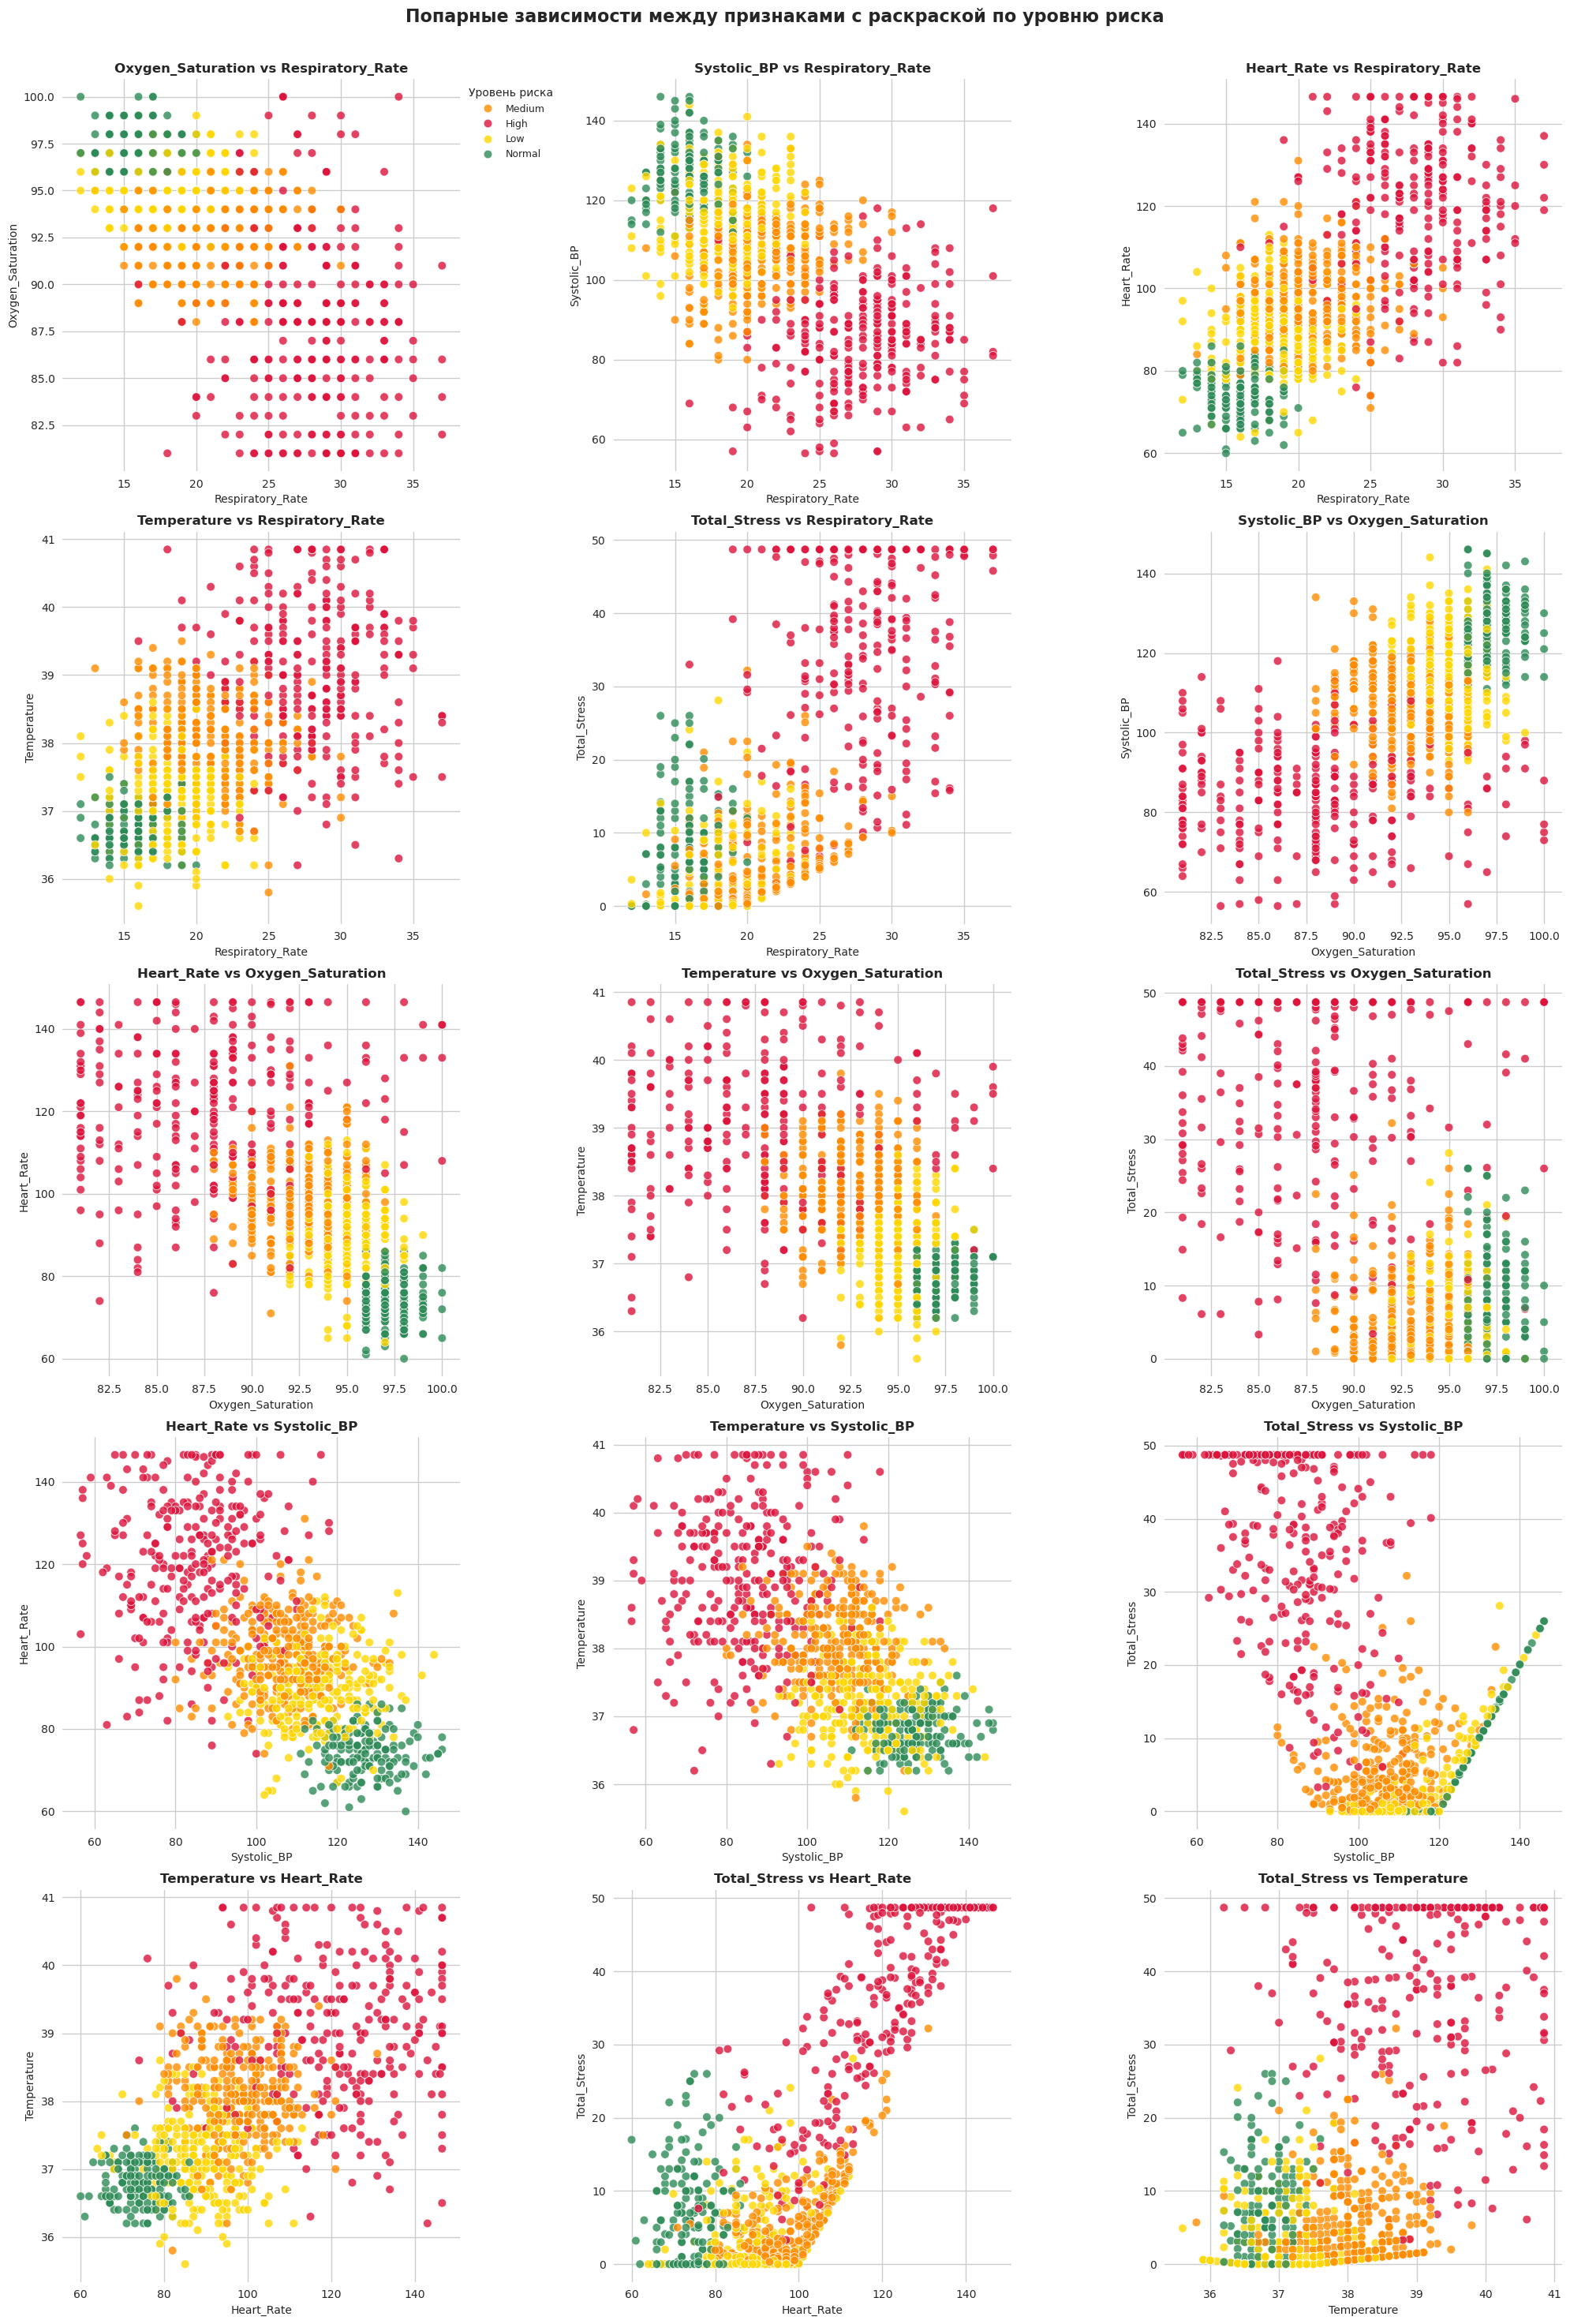

In [10]:
risk_palette = {
    'Normal': '#2E8B57',  # морской зеленый
    'Low': '#FFD700',     # золотой
    'Medium': '#FF8C00',  # темно-оранжевый
    'High': '#DC143C'     # малиновый
}

plt.style.use('seaborn-v0_8')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

feature_pairs = list(combinations(numeric_columns, 2))

n = len(feature_pairs)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
fig.suptitle('Попарные зависимости между признаками с раскраской по уровню риска', 
             fontsize=16, fontweight='bold', y=0.98)


axes = axes.flatten()
for i in range(n, len(axes)):
    fig.delaxes(axes[i])

for i, (x_feat, y_feat) in enumerate(feature_pairs):
    sns.scatterplot(data=df, x=x_feat, y=y_feat, hue='Risk_Level', 
                   palette=risk_palette, alpha=0.8, s=60, ax=axes[i])
    axes[i].set_title(f'{y_feat} vs {x_feat}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(x_feat, fontsize=10)
    axes[i].set_ylabel(y_feat, fontsize=10)
    
    if i == 0:
        axes[i].legend(title='Уровень риска', title_fontsize=10, fontsize=9, 
                      loc='upper left', bbox_to_anchor=(1, 1))
    else:
        axes[i].get_legend().remove()

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

### Анализ кластеров и групп в медицинских данных

На основе построенных scatter plots можно выделить следующие ярко выраженные кластеры и группы:

#### 1. Кислородная сатурация vs Частота дыхания
- **Кластер нормальных значений**: Сатурация >95%, частота дыхания 12-20 в минуту (преимущественно зеленые точки)
- **Кластер умеренных нарушений**: Сатурация 90-95%, частота дыхания 20-25 в минуту (желтые и оранжевые точки)
- **Кластер критических нарушений**: Сатурация <90%, частота дыхания >25 в минуту (красные точки)

#### 2. Систолическое давление vs ЧСС
- **Нормотензивная группа**: Давление 110-130 мм рт.ст., ЧСС 60-100 уд/мин
- **Гипертензивная группа**: Давление >140 мм рт.ст. с различными значениями ЧСС
- **Тахикардическая группа**: ЧСС >100 уд/мин при нормальном или повышенном давлении

#### 3. Температура vs Кислородная сатурация
- **Нормальная терморегуляция**: Температура 36-37°C, сатурация >95%
- **Лихорадочные состояния**: Температура >38°C с различной степенью снижения сатурации
- **Гипоксические состояния**: Сатурация <90% при нормальной или повышенной температуре

#### 4. Суммарный стресс vs Физиологические параметры
- **Низкий уровень стресса**: Низкие значения Total_Stress с нормальными физиологическими показателями
- **Высокий уровень стресса**: Высокие значения Total_Stress, коррелирующие с нарушениями по другим параметрам

#### Наиболее выраженные группы:
1. **Пациенты с дыхательной недостаточностью**: Низкая сатурация + высокая частота дыхания
2. **Пациенты с сердечно-сосудистыми нарушениями**: Высокое давление + высокий пульс
3. **Пациенты с системным воспалительным ответом**: Высокая температура + нарушения по multiple параметрам
4. **Пациенты в состоянии стресса**: Высокие значения Total_Stress + нарушения физиологических показателей

### **Приминение метода K-means для разбиения на кластеры**

#### *K-means работает только с числовыми данными, поэтому мы выбираем соответствующие признаки*

In [11]:
X = df[numeric_columns].copy()

#### K-means чувствителен к масштабу данные, признаки с большим диапазоном значений могут доминировать в вычислении расстояний, поэтому необходимо масштабировать данные

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Также надо определить оптимальное количество кластеров, для этого воспользуемся методом локтя (Elbow Method) и анализом силуэтного коэффициента (Silhouette Score)

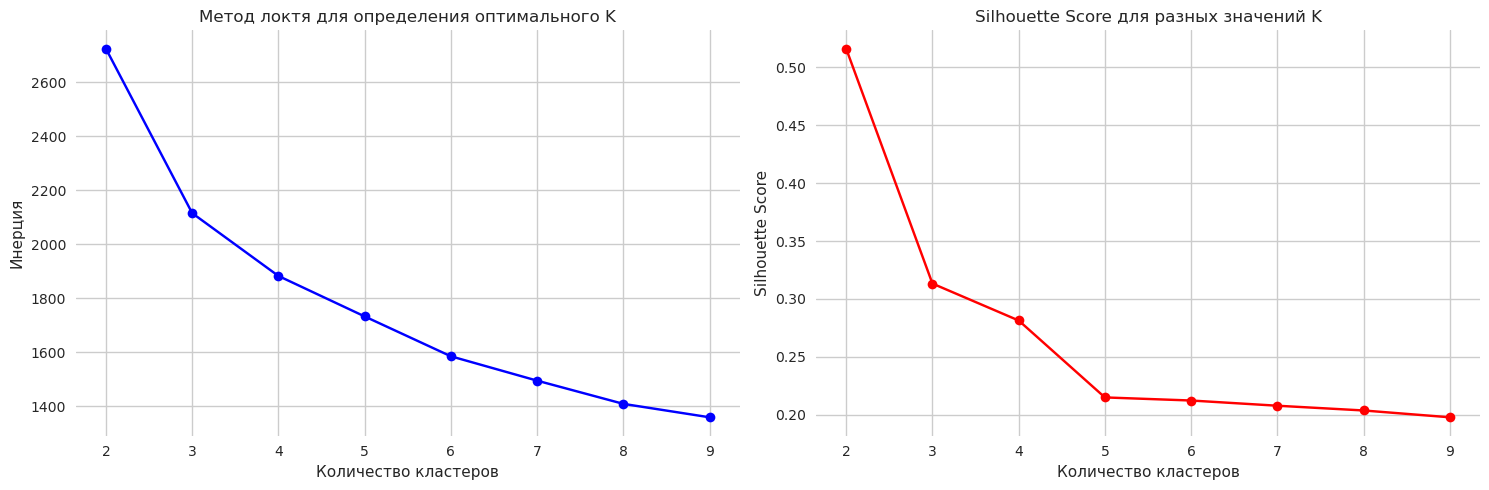

In [13]:
inertia = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(k_range, inertia, 'bo-')
ax1.set_xlabel('Количество кластеров')
ax1.set_ylabel('Инерция')
ax1.set_title('Метод локтя для определения оптимального K')

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Количество кластеров')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score для разных значений K')

plt.tight_layout()
plt.show()

#### Проанализировав графики, оптимальный k = 4
- На графике метода локтя нашел точку, где снижение инерции сильно замедляется (3-4)
- На графике анализа силуэтного коэффициента высокий показатель при k = 2, но разбиение медицинских данных на 2 класса малоинформативно


Центры кластеров (оригинальные значения):
   Respiratory_Rate  Oxygen_Saturation  Systolic_BP  Heart_Rate  Temperature  \
0         17.140299          96.092537   121.797015   81.271642    36.872537   
1         27.226804          86.237113    87.257732  103.711340    39.242784   
2         28.402235          88.463687    83.770950  130.178771    38.938547   
3         20.665810          93.156812   107.742931   97.061697    38.012082   

   Total_Stress  
0      5.296716  
1     22.011340  
2     43.843017  
3      4.995116  


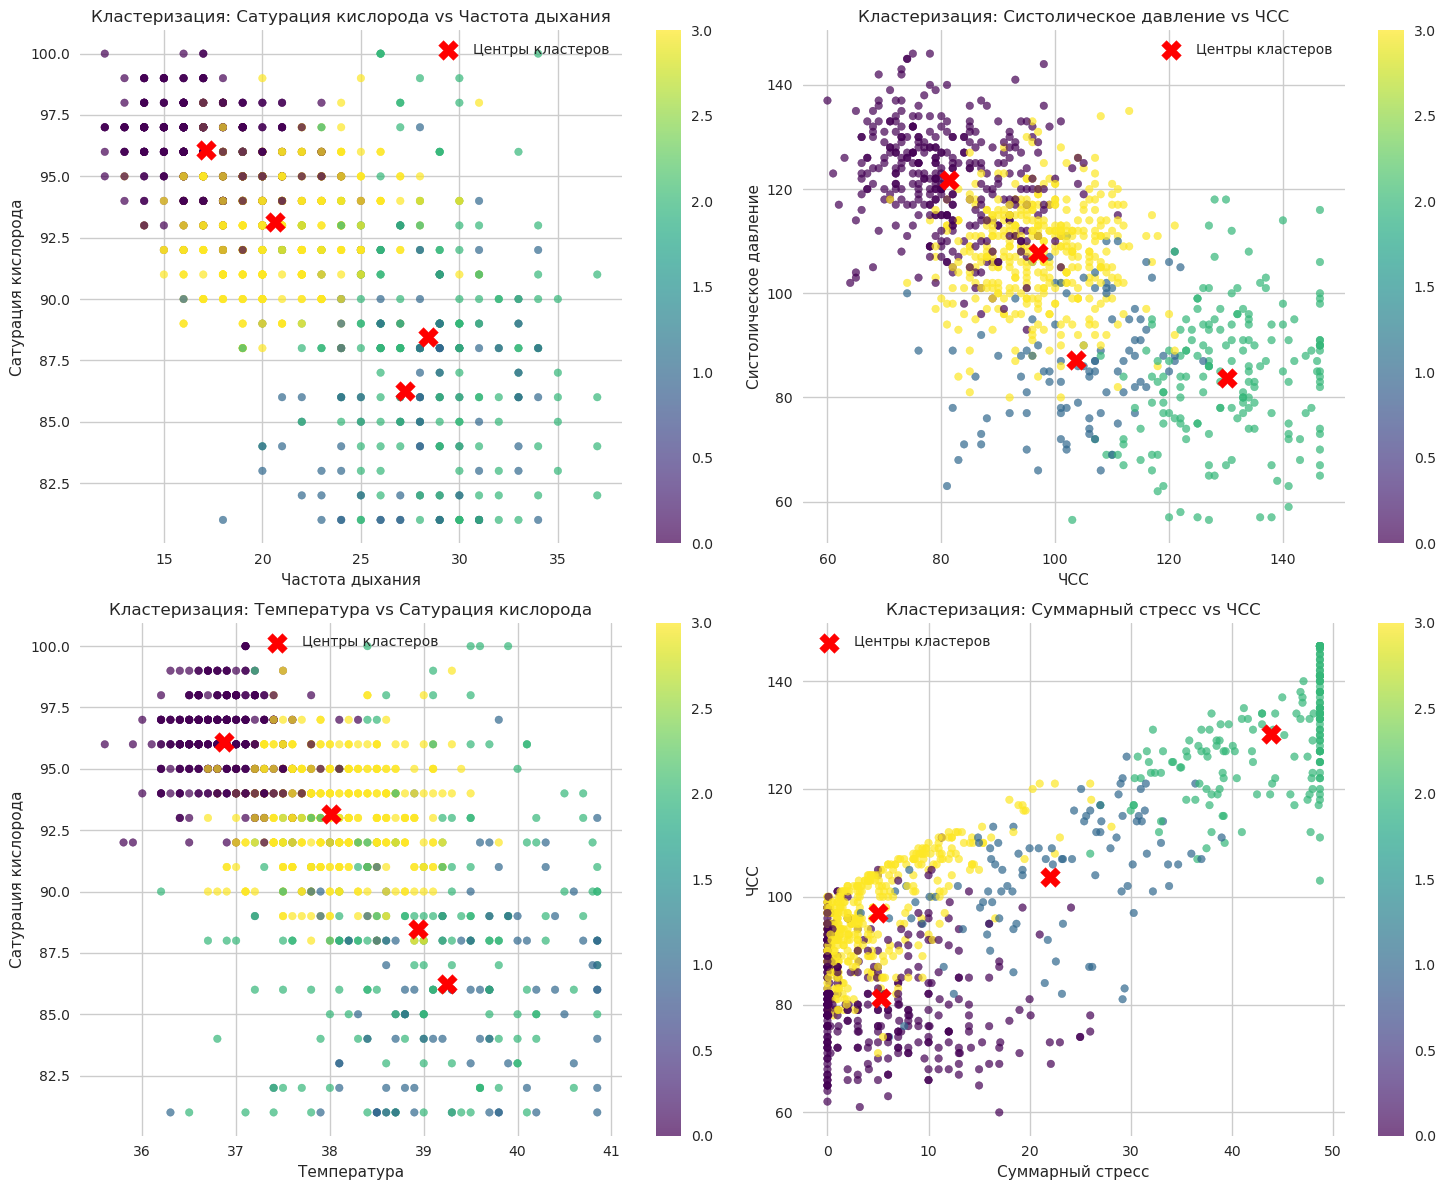

Средние значения признаков по кластерам:
         Respiratory_Rate  Oxygen_Saturation  Systolic_BP  Heart_Rate  \
Cluster                                                                 
0               17.140299          96.092537   121.797015   81.271642   
1               27.226804          86.237113    87.257732  103.711340   
2               28.402235          88.463687    83.770950  130.178771   
3               20.665810          93.156812   107.742931   97.061697   

         Temperature  Total_Stress  
Cluster                             
0          36.872537      5.296716  
1          39.242784     22.011340  
2          38.938547     43.843017  
3          38.012082      4.995116  


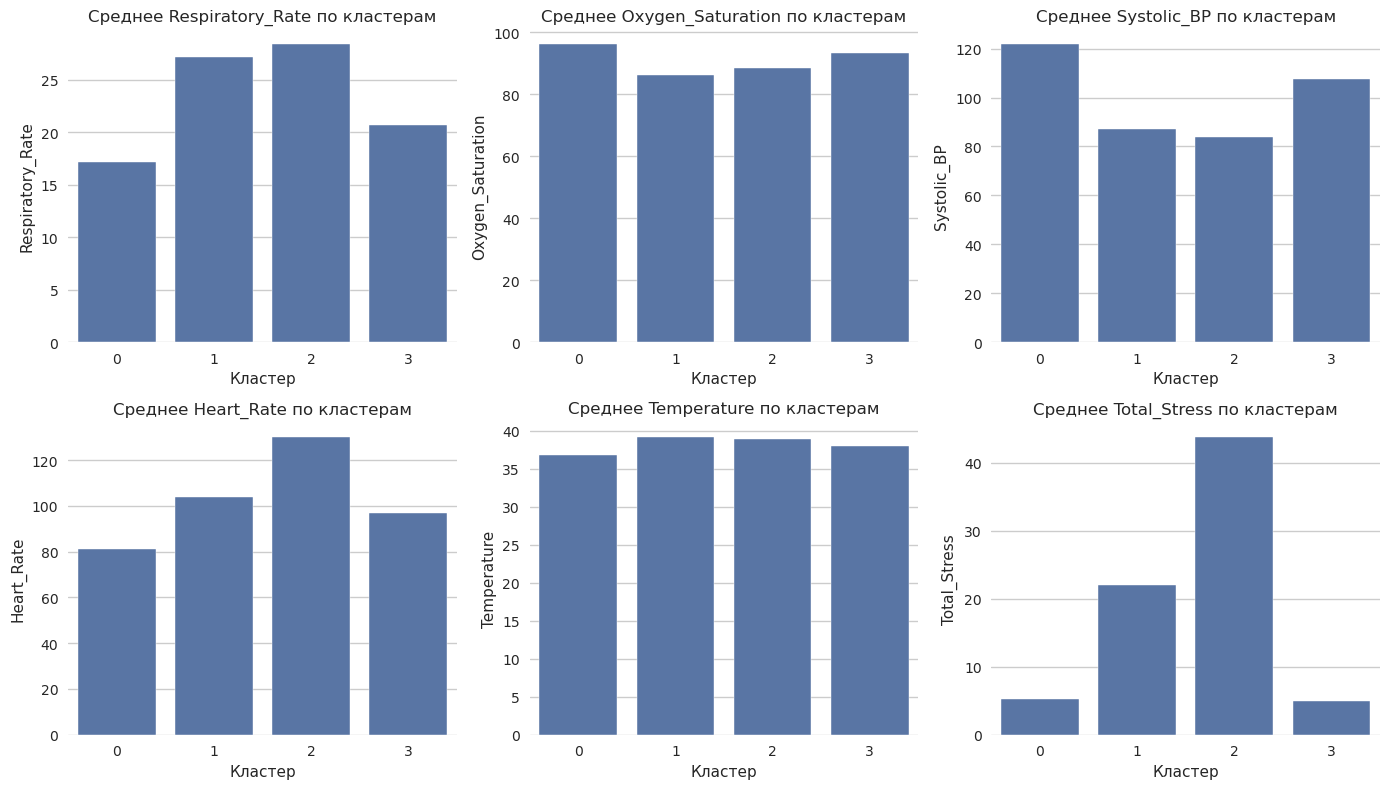

In [14]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=numeric_columns)

print("Центры кластеров (оригинальные значения):")
print(cluster_centers_df)

plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
scatter = plt.scatter(df['Respiratory_Rate'], df['Oxygen_Saturation'], 
                     c=df['Cluster'], cmap='viridis', alpha=0.7, s=30)
plt.scatter(cluster_centers_df['Respiratory_Rate'], cluster_centers_df['Oxygen_Saturation'],
            c='red', marker='X', s=200, label='Центры кластеров')
plt.xlabel('Частота дыхания')
plt.ylabel('Сатурация кислорода')
plt.title('Кластеризация: Сатурация кислорода vs Частота дыхания')
plt.legend()
plt.colorbar(scatter)

plt.subplot(2, 2, 2)
scatter = plt.scatter(df['Heart_Rate'], df['Systolic_BP'], 
                     c=df['Cluster'], cmap='viridis', alpha=0.7, s=30)
plt.scatter(cluster_centers_df['Heart_Rate'], cluster_centers_df['Systolic_BP'],
            c='red', marker='X', s=200, label='Центры кластеров')
plt.xlabel('ЧСС')
plt.ylabel('Систолическое давление')
plt.title('Кластеризация: Систолическое давление vs ЧСС')
plt.legend()
plt.colorbar(scatter)

plt.subplot(2, 2, 3)
scatter = plt.scatter(df['Temperature'], df['Oxygen_Saturation'], 
                     c=df['Cluster'], cmap='viridis', alpha=0.7, s=30)
plt.scatter(cluster_centers_df['Temperature'], cluster_centers_df['Oxygen_Saturation'],
            c='red', marker='X', s=200, label='Центры кластеров')
plt.xlabel('Температура')
plt.ylabel('Сатурация кислорода')
plt.title('Кластеризация: Температура vs Сатурация кислорода')
plt.legend()
plt.colorbar(scatter)

plt.subplot(2, 2, 4)
scatter = plt.scatter(df['Total_Stress'], df['Heart_Rate'], 
                     c=df['Cluster'], cmap='viridis', alpha=0.7, s=30)
plt.scatter(cluster_centers_df['Total_Stress'], cluster_centers_df['Heart_Rate'],
            c='red', marker='X', s=200, label='Центры кластеров')
plt.xlabel('Суммарный стресс')
plt.ylabel('ЧСС')
plt.title('Кластеризация: Суммарный стресс vs ЧСС')
plt.legend()
plt.colorbar(scatter)

plt.tight_layout()
plt.show()

cluster_stats = df.groupby('Cluster')[numeric_columns].mean()
print("Средние значения признаков по кластерам:")
print(cluster_stats)

plt.figure(figsize=(14, 8))
for i, feature in enumerate(numeric_columns):
    plt.subplot(2, 3, i+1)
    sns.barplot(x=cluster_stats.index, y=cluster_stats[feature])
    plt.title(f'Среднее {feature} по кластерам')
    plt.xlabel('Кластер')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

## **Вывод**

В ходе проделанной работы с медицинским датасетом были приобретены и применены важные навыки анализа данных: добавление нового информативного атрибута (суммарный стресс, Total_Stress) для расширения возможностей оценки состояния пациентов, тщательная предобработка данных — удаление дублей, выявление и обработка выбросов, а также визуальный анализ взаимосвязей между признаками с выявлением ярко выраженных групп и кластеров по уровням риска. Изучение и применение на практике метода KMeans позволили разделить пациентов на несколько однородных кластеров, отражающих различные профили состояния здоровья.

Полученный анализ медицинских данных выявил чёткие группы пациентов с различным уровнем физиологического стресса и изменениями в жизненных показателях. Введённый атрибут Total_Stress помог аггрегировать влияние отклонений по частоте дыхания, пульсу, температуре и давлению, что улучшило дифференциацию риска. Кластеризация дала возможность выделить четыре основные подгруппы, каждая из которых характеризуется своим набором признаков и уровнем клинической нагрузки.